# Image captioning using Keras - Train

In [2]:
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import applications
from keras.utils.vis_utils import plot_model

### Load the InceptionV3 model

We will be using InceptionV3 a model developed by Google to obtain the features vectors of the images.Inception v3 is a widely-used image recognition model that has been shown to attain greater than 78.1% accuracy on the ImageNet dataset. More information on InceptionV3 can be found [here](https://keras.io/api/applications/inceptionv3/#inceptionv3-function).

In [3]:
model = tf.keras.applications.InceptionV3()
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

We won't be requiring the last Dense layer with Softmax activation. Hence we will construct a new model with the output of the last before layer as the feature extracter model.

In [4]:
model2 = Model(model.input, model.layers[-2].output)

### Load the pre-processed images

In [5]:
w2s = np.load('word2seq.npy',allow_pickle='TRUE').item()
s2w = np.load('seq2word.npy',allow_pickle='TRUE').item()

encoder_input = np.load('encoder_input.npy')
decoder_stuff = np.load('decoder_stuff.npy')

### Let's check once

 total number of images : 8091 
 total number of captions : 40455 

['ST', 'man', 'uses', 'ice', 'picks', 'crampons', 'scale', 'ice', 'ET', '', '', '', '', '', '', '', '', '', '', '', '', '']


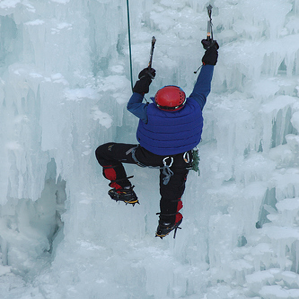

In [6]:
print(' total number of images :',len(encoder_input),'\n','total number of captions :',len(decoder_stuff),'\n')
lis = []

for i in decoder_stuff[105] : # Each image has 5 corresponding captions. So 21*5 = 105
    lis.append(s2w[i])
    
print(lis)

tf.keras.preprocessing.image.array_to_img(encoder_input[21])

### Use MobileNetV2 to get the feature vectors

In [7]:
feat_vect = []
for i in range(len(encoder_input)):
    feat_vect.append([model2.predict(encoder_input[i].reshape((1,299,299,3)))])

feat_vect_stacked = np.stack(feat_vect)

Duplicate every image 4 times, as each image has 5 captions.

In [8]:
feat_vect_stacked_duplicated = []

for i in range(len(feat_vect_stacked)):
    for j in range(5):
        feat_vect_stacked_duplicated.append(feat_vect_stacked[i])
        
feat_vect_stacked_duplicated_stacked = np.stack(feat_vect_stacked_duplicated)

In [9]:
feat_vect_stacked_duplicated_stacked.shape

(40455, 1, 1, 2048)

In [10]:
feat_vect_final = feat_vect_stacked_duplicated_stacked.reshape((40455,1,2048))

In [13]:
decoder_input = []
decoder_output = []

for i in range(len(decoder_stuff)):
    decoder_input.append(decoder_stuff[i][:-1])
    decoder_output.append(decoder_stuff[i][1:])

decoder_input = np.stack(decoder_input)
decoder_output = np.stack(decoder_output)

In [16]:
print('Shape of feature vector :', feat_vect_final[0].shape)
print('Shape of input sequence :', decoder_input[0].shape)

Shape of feature vector : (1, 2048)
Shape of input sequence : (21,)


### Build Model

Will be using functional API of Keras. The model's architecture can be found in the README. <br />
Feel free to tune the hyper parameters.

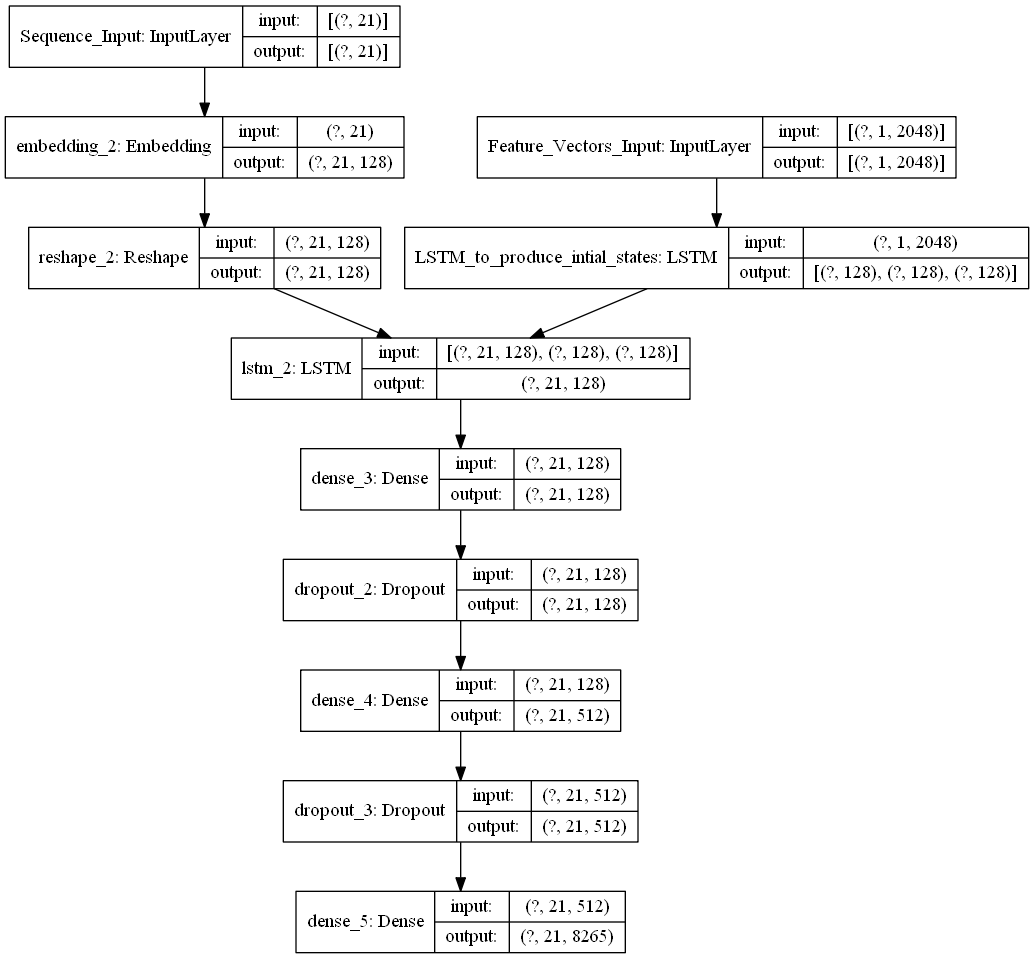

In [20]:
# Input layer for the images
img_inp = keras.Input(shape = (1,2048), name = 'Feature_Vectors_Input') # 2048 --> length of feature vector
LSTM_img = keras.layers.LSTM(units = 128, return_state = True, name = 'LSTM_to_produce_intial_states')

# When I tried states = LSTM_img.states it threw an error when re-using the states in the layer LSTM_decod.
flag1, s1, s2 = LSTM_img(img_inp) 
states = [s1,s2]

# Input layer for the sequence
inp = keras.Input(shape = (21), name = 'Sequence_Input')
Embed_layer = keras.layers.Embedding(input_dim = len(w2s), output_dim = 128)
embedded = Embed_layer(inp)

reshaped = keras.layers.Reshape((21,128))(embedded)

# Setting return_sequences = true returns the whole prediction instead of the last prediction alone
LSTM_decod = keras.layers.LSTM(units = 128, return_sequences = True)(reshaped, initial_state = states) 

Dense_output0 = keras.layers.Dense(128, activation = 'relu')(LSTM_decod)

Dropout_output0 = tf.keras.layers.Dropout(0.5)(Dense_output0)

Dense_output1 = keras.layers.Dense(512, activation = 'relu')(Dropout_output0)

Dropout_output1 = tf.keras.layers.Dropout(0.5)(Dense_output1)

Densed = keras.layers.Dense(units = len(w2s), activation = 'softmax')(Dropout_output1)

captioning_model = Model([img_inp,inp],Densed)

plot_model(captioning_model, show_shapes=True, show_layer_names=True)

### Compile and fit model

In [22]:
captioning_model.compile(optimizer = 'adam', 
                         loss = 'sparse_categorical_crossentropy', 
                         metrics = ['sparse_categorical_accuracy'])

# This function keeps the initial learning rate for the first ten epochs and decreases it exponentially after that.
def scheduler(epoch, lr):
    if epoch < 40:
        return lr
    else:
        return lr * tf.math.exp(-0.05)

# Callback 1 - Schedule learning rate     
model_learning_rate = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Callback 2 - Save only the set of weights which gives the best result 
checkpoint_filepath = 'best_weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint( 
                    filepath = checkpoint_filepath,
                    save_weights_only = True, # True -> Save weigths, False -> Save Model
                    monitor = 'val_loss', mode = 'min', # Save the weights which prodeuces "max val_accuracy"
                    save_best_only = True, verbose = 0 )

hist = captioning_model.fit([feat_vect_final, decoder_input], decoder_output,
                             epochs = 1, validation_split = 0.15,
                             callbacks = [model_checkpoint_callback, model_learning_rate],
                             batch_size = 1000)

35/35 [==============================] - 429s 12s/step - loss: 2.0172 - sparse_categorical_accuracy: 0.7264 - val_loss: 1.8520 - val_sparse_categorical_accuracy: 0.7331 - lr: 0.0010


Note that the number of epochs is just 1. For 1 epoch, validation accuracy = 0.7331 and validation loss = 1.8520 <br>
For better results fit the model for greater number of epochs.

### Model for predicting

In [43]:
len_seq = 2 # This represents the length of the sequence which is fed into the Embedding layer
            # More the value, better the result

# Input the test image
img_inp = keras.Input(shape = (1,2048), name = 'Feature_Vectors_Input') # 1280 --> length of feature vector

Dense_img = keras.layers.Dense(128, activation = 'relu')(img_inp)

LSTM_img = keras.layers.LSTM(units = 216, return_state = True, name = 'LSTM_to_produce_intial_states')

flag1, s1, s2 = LSTM_img(Dense_img) 

states = [s1,s2]

inp = keras.Input(shape = len_seq, name = 'Sequence_Input')

Embed_layer = keras.layers.Embedding(input_dim = len(w2s), output_dim = 100)
embedded = Embed_layer(inp)

reshaped = keras.layers.Reshape((len_seq,100))(embedded)

# Setting return_sequences = False returns the last prediction alone
LSTM_decod = keras.layers.LSTM(units = 216, return_sequences = False)(reshaped, initial_state = states) 

Dense_output0 = keras.layers.Dense(128, activation = 'relu')(LSTM_decod)

Dropout_output0 = tf.keras.layers.Dropout(0.5)(Dense_output0)

Dense_output1 = keras.layers.Dense(512, activation = 'relu')(Dropout_output0)

Dropout_output1 = tf.keras.layers.Dropout(0.5)(Dense_output1)

Densed = keras.layers.Dense(units = len(w2s), activation = 'softmax')(Dropout_output1)

predicting_model = Model([img_inp,inp],Densed)

Note that this model is almost a replica of the previous model except for the length of the sequence input. 